In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# import nest_asyncio
# nest_asyncio.apply()
from requests_html import HTML, HTMLSession, AsyncHTMLSession
from threading import Thread
import time
import string

In [2]:
df = pd.read_csv(r'C:\Users\Toby-PC\Documents\code\audible\all_english_audible.csv')
df = df[~df['asin'].isnull()]

image_path = r'C:\Users\Toby-PC\Documents\code\audible\figures'

def save_fig(fig_name, tight_layout=True):
    path = os.path.join(image_path, fig_name + '.png')
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
df = df.drop_duplicates()

In [4]:
total_ratings = df['rating_count'].sum()
total_ratings

64023215.0

In [5]:
df = df.sort_values('rating_count', ascending=False)
df.reset_index(inplace=True)

In [6]:
df.head()

,index,asin,author,category,length,link,narrator,price,rating,rating_count,release_date,title
0,247928,B005FRGT44,Ernest Cline,Sci-Fi & Fantasy,15 hrs and 40 mins,https://www.audible.com/pd/Ready-Player-One-Au...,Wil Wheaton,31.50,5.0,216094.0,2011-08-16,Ready Player One
1,248009,B00B5HZGUG,Andy Weir,Sci-Fi & Fantasy,10 hrs and 53 mins,https://www.audible.com/pd/The-Martian-Audiobo...,R. C. Bray,29.99,5.0,164988.0,2013-03-22,The Martian
2,142087,B00QXW5GYY,Paula Hawkins,Mysteries & Thrillers,10 hrs and 58 mins,https://www.audible.com/pd/The-Girl-on-the-Tra...,"Clare Corbett, Louise Brealey, India Fisher",28.00,4.5,133818.0,2015-01-13,The Girl on the Train
3,4895,B01IW9TQPK,Trevor Noah,Bios & Memoirs,8 hrs and 44 mins,https://www.audible.com/pd/Born-a-Crime-Audiob...,Trevor Noah,24.95,5.0,123838.0,2016-11-15,Born a Crime
4,282008,B01I28NFEE,Mark Manson,Self Development,5 hrs and 17 mins,https://www.audible.com/pd/The-Subtle-Art-of-N...,Roger Wayne,23.95,4.5,113261.0,2016-09-13,The Subtle Art of Not Giving a F*ck


Saving figure Index vs Cum Reviews


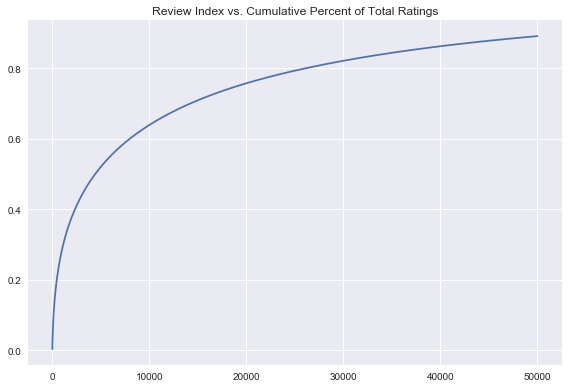

In [7]:
plt.style.use('seaborn')
top_n = 50000
x = list(range(top_n))
cumsum = df.iloc[:top_n]['rating_count'].cumsum()/total_ratings
plt.plot(x, cumsum);
plt.title('Review Index vs. Cumulative Percent of Total Ratings')
save_fig('Index vs Cum Reviews')

In [8]:
len(df)

436796

In [18]:
cutoff_ind = cumsum[cumsum>0.8].index[0]
df = df.iloc[7978:cutoff_ind]
cutoff_ind

26101

In [10]:
df_items = df[['asin', 'title', 'author']]
program_list = [tuple(x) for x in df_items.values]

In [11]:
def normalize(s):
    s = s.replace('.', ' stop ')
    s = s.replace('\n', ' ')
    for p in string.punctuation:
        s = s.replace(p, '')
    return s.lower().strip()


def get_overall_rating(asin, rating_dict):
    sess = HTMLSession()
    r = sess.get(f"https://www.audible.com/pd/{asin}")
    rating_dict[asin] = np.float(r.html.find('div.bc-row.bc-spacing-small', 
                                             first=False)[1].text.split(' stars ')[1][:3])
    sess.close()
    return rating_dict


def get_reviews(asin, title, author):
    baseurl = f'https://www.audible.com/pd/reviews?country=US&asin={asin}&page='
    page_num = 0
    ratings_reviews = []
    sess = HTMLSession()
    title = normalize(title)
    try:
        author = normalize(author)
    except:
        author = '<auth>'
    
    while True:
        try:
            url = baseurl + str(page_num)
            r = sess.get(url).html
            page_elements = r.find('div.bc-row-responsive.bc-spacing-top-medium', first=False)
            for elem in page_elements:
                try:
                    review = elem.find(f'div.bc-col-responsive.USreviews{page_num}.bc-col-9', first=True).text
                    review = normalize(review)
                    review = review.replace(title, '<unk>').replace(author, '<unk>')
                    ratings = [item.text[0] for item in elem.find('span.bc-text')]
                    ratings_reviews.append((review, *ratings))
                except:
                    break
            page_num += 1
            
        except:
            break
    
    sess.close()
    return ratings_reviews


def get_ratings_and_reviews(program_group, rating_dict, reviews):
    for asin, title, author in program_group:
        try:
            rating_dict = (get_overall_rating(asin, rating_dict))
        except:
            pass
        reviews.extend(get_reviews(asin, title, author))
#         print(reviews)
    return rating_dict, reviews

In [12]:
def threaded_ratings(nthreads, program_list, rating_dict=None, reviews=None):
    if rating_dict == None:
        rating_dict = {}
        
    if reviews == None:
        reviews = []
        
    threads = []
    for i in range(nthreads):
        program_group = program_list[i::nthreads]
        t = Thread(target=get_ratings_and_reviews, args=(program_group, rating_dict, reviews))
        threads.append(t)
        
    [t.start() for t in threads]
    [t.join() for t in threads]
    
    return rating_dict, reviews

In [13]:
start = time.time()
rating_dict = {}
rating_dict, reviews = threaded_ratings(16, program_list[::-1], rating_dict)
end = time.time()
print(end-start)

7308.237472772598


In [14]:
len(reviews)

822922

In [15]:
df_reviews = pd.DataFrame(data=reviews, columns=['text', 'overall', 'performance', 'story'])

In [16]:
df_reviews.to_csv('reviews2.csv', index=False)

In [17]:
df_ratings = pd.DataFrame.from_dict(data=rating_dict, orient='index', columns=['rating'])

In [18]:
df_ratings['asin'] = df_ratings.index

In [19]:
df_ratings.reset_index(drop=True, inplace=True)

In [20]:
df.drop('rating', inplace=True, axis=1)

In [21]:
df_merged = pd.merge(df, df_ratings, on='asin')

In [22]:
df_merged.to_csv('8k_top_granular_audible2.csv')